In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gradient-descent/AI-InvestorFinalProjectPart2.docx
/kaggle/input/gradient-descent/sample_submission.csv
/kaggle/input/gradient-descent/bureau_balance.csv
/kaggle/input/gradient-descent/POS_CASH_balance.csv
/kaggle/input/gradient-descent/application_train.csv
/kaggle/input/gradient-descent/HomeCredit_columns_description.csv
/kaggle/input/gradient-descent/AI-InvestorFinalProject.docx
/kaggle/input/gradient-descent/application_test.csv
/kaggle/input/gradient-descent/previous_application.csv
/kaggle/input/gradient-descent/constituents_csv.csv
/kaggle/input/gradient-descent/credit_card_balance.csv
/kaggle/input/gradient-descent/installments_payments.csv
/kaggle/input/gradient-descent/bureau.csv


In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/kaggle/input/gradient-descent/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/kaggle/input/gradient-descent/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


In [4]:
from catboost import CatBoostClassifier


Train samples: 307511, test samples: 48744
Starting LightGBM. Train shape: (307507, 248), test shape: (48744, 248)


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.774705	training's binary_logloss: 0.241492	valid_1's auc: 0.76061	valid_1's binary_logloss: 0.250624
[400]	training's auc: 0.793039	training's binary_logloss: 0.235213	valid_1's auc: 0.76696	valid_1's binary_logloss: 0.248285
[600]	training's auc: 0.805942	training's binary_logloss: 0.231025	valid_1's auc: 0.768789	valid_1's binary_logloss: 0.247595
[800]	training's auc: 0.816932	training's binary_logloss: 0.227412	valid_1's auc: 0.769609	valid_1's binary_logloss: 0.247258
[1000]	training's auc: 0.826627	training's binary_logloss: 0.224124	valid_1's auc: 0.769926	valid_1's binary_logloss: 0.247152
Fold  1 AUC : 0.770105


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.774547	training's binary_logloss: 0.24208	valid_1's auc: 0.761697	valid_1's binary_logloss: 0.245617
[400]	training's auc: 0.792338	training's binary_logloss: 0.235938	valid_1's auc: 0.768772	valid_1's binary_logloss: 0.243026
[600]	training's auc: 0.805635	training's binary_logloss: 0.231632	valid_1's auc: 0.771788	valid_1's binary_logloss: 0.242089
[800]	training's auc: 0.816231	training's binary_logloss: 0.228138	valid_1's auc: 0.772889	valid_1's binary_logloss: 0.241735
[1000]	training's auc: 0.82554	training's binary_logloss: 0.22496	valid_1's auc: 0.773511	valid_1's binary_logloss: 0.241562
[1200]	training's auc: 0.834222	training's binary_logloss: 0.22191	valid_1's auc: 0.77375	valid_1's binary_logloss: 0.241479
[1400]	training's auc: 0.841948	training's binary_logloss: 0.219078	valid_1's auc: 0.773626	valid_1's binary_logloss: 0.241531
F

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.7752	training's binary_logloss: 0.24156	valid_1's auc: 0.753479	valid_1's binary_logloss: 0.25056
[400]	training's auc: 0.793244	training's binary_logloss: 0.235356	valid_1's auc: 0.761033	valid_1's binary_logloss: 0.248065
[600]	training's auc: 0.806001	training's binary_logloss: 0.231211	valid_1's auc: 0.763264	valid_1's binary_logloss: 0.247386
[800]	training's auc: 0.816999	training's binary_logloss: 0.227596	valid_1's auc: 0.764348	valid_1's binary_logloss: 0.247025
[1000]	training's auc: 0.826516	training's binary_logloss: 0.224296	valid_1's auc: 0.764618	valid_1's binary_logloss: 0.246911
Fold  3 AUC : 0.764797


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.774764	training's binary_logloss: 0.242081	valid_1's auc: 0.763152	valid_1's binary_logloss: 0.245333
[400]	training's auc: 0.79229	training's binary_logloss: 0.236024	valid_1's auc: 0.770597	valid_1's binary_logloss: 0.242672
[600]	training's auc: 0.805422	training's binary_logloss: 0.231776	valid_1's auc: 0.773195	valid_1's binary_logloss: 0.241765
[800]	training's auc: 0.816281	training's binary_logloss: 0.228225	valid_1's auc: 0.774228	valid_1's binary_logloss: 0.241418
[1000]	training's auc: 0.82572	training's binary_logloss: 0.225043	valid_1's auc: 0.774345	valid_1's binary_logloss: 0.241319
Fold  4 AUC : 0.774457


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.774719	training's binary_logloss: 0.242756	valid_1's auc: 0.762138	valid_1's binary_logloss: 0.238589
[400]	training's auc: 0.792387	training's binary_logloss: 0.236622	valid_1's auc: 0.769596	valid_1's binary_logloss: 0.236126
[600]	training's auc: 0.805213	training's binary_logloss: 0.232434	valid_1's auc: 0.772115	valid_1's binary_logloss: 0.235351
[800]	training's auc: 0.81603	training's binary_logloss: 0.228868	valid_1's auc: 0.773109	valid_1's binary_logloss: 0.235033
[1000]	training's auc: 0.825698	training's binary_logloss: 0.225616	valid_1's auc: 0.773161	valid_1's binary_logloss: 0.234975
Fold  5 AUC : 0.773449


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.775496	training's binary_logloss: 0.241828	valid_1's auc: 0.753497	valid_1's binary_logloss: 0.247102
[400]	training's auc: 0.79334	training's binary_logloss: 0.235604	valid_1's auc: 0.759892	valid_1's binary_logloss: 0.245019
[600]	training's auc: 0.806392	training's binary_logloss: 0.231348	valid_1's auc: 0.762082	valid_1's binary_logloss: 0.244366
[800]	training's auc: 0.816828	training's binary_logloss: 0.227839	valid_1's auc: 0.762451	valid_1's binary_logloss: 0.244207
[1000]	training's auc: 0.826487	training's binary_logloss: 0.224508	valid_1's auc: 0.76289	valid_1's binary_logloss: 0.244089
Fold  6 AUC : 0.763043


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.774508	training's binary_logloss: 0.24216	valid_1's auc: 0.760519	valid_1's binary_logloss: 0.244999
[400]	training's auc: 0.792132	training's binary_logloss: 0.236094	valid_1's auc: 0.768014	valid_1's binary_logloss: 0.242475
[600]	training's auc: 0.805003	training's binary_logloss: 0.231873	valid_1's auc: 0.769956	valid_1's binary_logloss: 0.241807
[800]	training's auc: 0.815788	training's binary_logloss: 0.228272	valid_1's auc: 0.770971	valid_1's binary_logloss: 0.24148
[1000]	training's auc: 0.825465	training's binary_logloss: 0.224991	valid_1's auc: 0.771183	valid_1's binary_logloss: 0.241416
[1200]	training's auc: 0.833889	training's binary_logloss: 0.222004	valid_1's auc: 0.771348	valid_1's binary_logloss: 0.241367
Fold  7 AUC : 0.771439


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.775098	training's binary_logloss: 0.241666	valid_1's auc: 0.756288	valid_1's binary_logloss: 0.24908
[400]	training's auc: 0.792358	training's binary_logloss: 0.235633	valid_1's auc: 0.76377	valid_1's binary_logloss: 0.246621
[600]	training's auc: 0.804866	training's binary_logloss: 0.231554	valid_1's auc: 0.766551	valid_1's binary_logloss: 0.245785
[800]	training's auc: 0.815676	training's binary_logloss: 0.227978	valid_1's auc: 0.768422	valid_1's binary_logloss: 0.245302
[1000]	training's auc: 0.825482	training's binary_logloss: 0.224639	valid_1's auc: 0.769272	valid_1's binary_logloss: 0.245071
[1200]	training's auc: 0.834127	training's binary_logloss: 0.221652	valid_1's auc: 0.769598	valid_1's binary_logloss: 0.245003
Fold  8 AUC : 0.769662


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.774561	training's binary_logloss: 0.241875	valid_1's auc: 0.766095	valid_1's binary_logloss: 0.24639
[400]	training's auc: 0.792116	training's binary_logloss: 0.235797	valid_1's auc: 0.772584	valid_1's binary_logloss: 0.243906
[600]	training's auc: 0.805149	training's binary_logloss: 0.231554	valid_1's auc: 0.774214	valid_1's binary_logloss: 0.243258
[800]	training's auc: 0.815932	training's binary_logloss: 0.228007	valid_1's auc: 0.77511	valid_1's binary_logloss: 0.242925
[1000]	training's auc: 0.825672	training's binary_logloss: 0.224692	valid_1's auc: 0.775675	valid_1's binary_logloss: 0.242692
[1200]	training's auc: 0.834303	training's binary_logloss: 0.221676	valid_1's auc: 0.775574	valid_1's binary_logloss: 0.242698
Fold  9 AUC : 0.775719


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.775496	training's binary_logloss: 0.242035	valid_1's auc: 0.755245	valid_1's binary_logloss: 0.245119
[400]	training's auc: 0.792781	training's binary_logloss: 0.236009	valid_1's auc: 0.762907	valid_1's binary_logloss: 0.242626
[600]	training's auc: 0.805742	training's binary_logloss: 0.231744	valid_1's auc: 0.765108	valid_1's binary_logloss: 0.241938
[800]	training's auc: 0.816579	training's binary_logloss: 0.228109	valid_1's auc: 0.766008	valid_1's binary_logloss: 0.241645
[1000]	training's auc: 0.825964	training's binary_logloss: 0.22492	valid_1's auc: 0.766467	valid_1's binary_logloss: 0.241552
[1200]	training's auc: 0.834491	training's binary_logloss: 0.221889	valid_1's auc: 0.766816	valid_1's binary_logloss: 0.24146
[1400]	training's auc: 0.842186	training's binary_logloss: 0.219055	valid_1's auc: 0.767055	valid_1's binary_logloss: 0.24140

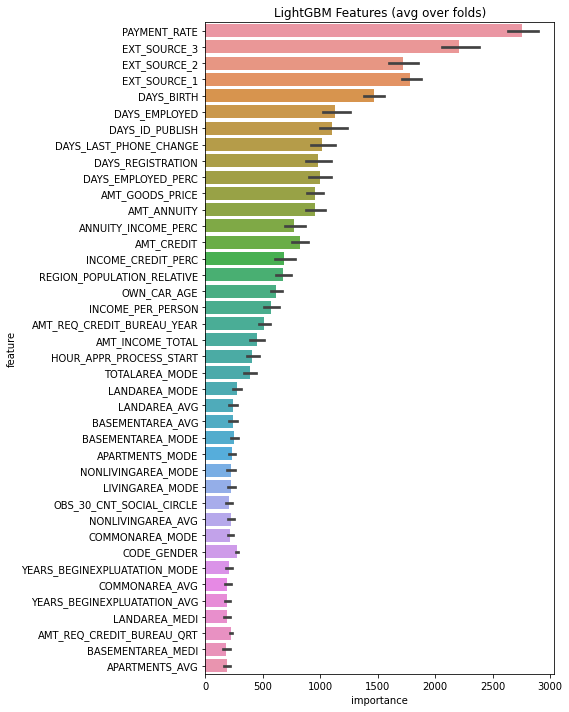

In [5]:

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        """
        clf = CatBoostClassifier(
            iterations=5, 
            learning_rate=0.1, 
            #loss_function='CrossEntropy'
        )
        """
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            boosting_type = 'goss',  ### Added as per notebook comments ###
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    """
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    """
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

#if __name__ == "__main__":
submission_file_name = "submission_kernel02.csv"
with timer("Full model run"):
    """
    [LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
    [200]	training's auc: 0.774705	training's binary_logloss: 0.241492	valid_1's auc: 0.76061	valid_1's binary_logloss: 0.250624
    [400]	training's auc: 0.793039	training's binary_logloss: 0.235213	valid_1's auc: 0.76696	valid_1's binary_logloss: 0.248285
    [600]	training's auc: 0.805942	training's binary_logloss: 0.231025	valid_1's auc: 0.768789	valid_1's binary_logloss: 0.247595
    [800]	training's auc: 0.816932	training's binary_logloss: 0.227412	valid_1's auc: 0.769609	valid_1's binary_logloss: 0.247258
    [1000]	training's auc: 0.826627	training's binary_logloss: 0.224124	valid_1's auc: 0.769926	valid_1's binary_logloss: 0.247152
    Fold  1 AUC : 0.770105
    "
    [LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
    [200]	training's auc: 0.774547	training's binary_logloss: 0.24208	valid_1's auc: 0.761697	valid_1's binary_logloss: 0.245617
    [400]	training's auc: 0.792338	training's binary_logloss: 0.235938	valid_1's auc: 0.768772	valid_1's binary_logloss: 0.243026


    """
    main()